In [2]:
import numpy as np
import pandas as pd
import gzip
import json

from pprint import pprint

In [3]:
#@title Turkish StopWords

import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
turkish_stopwords = stopwords.words('turkish')

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>


## Uploading the data
- We form two dictionaries: first one is for tracking post informations, socond one is for tracking profile informations

In [4]:
import json

train_data_path = "training-dataset.jsonl.gz"

posts_train = dict()
profiles = dict()

with gzip.open(train_data_path, "rt") as fh:
  for line in fh:
    sample = json.loads(line)
    profile = sample["profile"]
    username = profile["username"]
    posts_train[username] = sample["posts"]
    profiles[username] = profile



# Feature extraction
#### I believe that this is the most important part, we tried different combinations of features to maximize model performance. Some features seem important but end up downgrading the model. For example 'post_count' feature contains lots of zeros, so it didn't contribute much to our model, we cut it off. 
#### Also dividing timestamp feature into some representative subgroups ended up boosting our model performance. We created day_of_week and day_of_year because they could represent important times like a special day or holiday for day_of_week. For day_of_year, the value could represent seasonal effect like summer times having high like count. Then I divided days into 4 groups (Midnight, Morning, Afternoon, Evening), these are good representatives as posts are more likely to get more likes at some points of the day.
#### We also calculated the caption length and hastag numbers.

In [5]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

def get_avg_like_count(username):
    def calculate_avg(posts: list):
        total = 0
        count = 0
        for post in posts:
            like_count = post.get("like_count", 0)
            if like_count is None:
                like_count = 0
            total += like_count
            count += 1

        return total / count if count > 0 else 0

    # Check if the username exists in training or testing data
    if username in posts_train:
        return calculate_avg(posts_train[username])
    else:
        print(f"No data available for {username}")
        return -1

# Initialize an empty list to store rows
data = []
# Loop through usernames in the training set
for username, posts in posts_train.items():
    # Get profile info for the user
    profile = profiles[username]

    average_like = get_avg_like_count(username)
    # Extract profile-related features
    profile_info = {
        #"username": username,
        "follower_count": profile.get("follower_count", 0) or 0,
        "following_count": profile.get("following_count", 0) or 0,
        "highlight_reel_count": profile.get("highlight_reel_count", 0) or 0,
        #"post_count": profile.get("post_count", 0) or 0,
        "is_verified": profile.get("is_verified", False),
        "is_business_account": profile.get("is_business_account", False),
        "is_private": profile.get("is_private", False),
        "category_name": profile.get("category_name", "Unknown"),
        "average_like": average_like,
        "username": profile.get("username", "Unknown")
    }
    
    # Loop through posts and extract post-related features
    for post in posts:
        caption = post.get("caption", "")
        if caption is None:
            caption = ""
        post_info = {
            "media_type": post.get("media_type", 0),
            "comments_count": post.get("comments_count", 0) or 0,
            "like_count": post.get("like_count", 0) or 0,
            "timestamp": post.get("timestamp", ""),
            "post_length": len(caption),
            "hashtags_count": caption.count("#"),
        }
        
        # Combine profile and post info
        combined_info = {**profile_info, **post_info}
        data.append(combined_info)

# Convert the list of dictionaries into a DataFrame
df_train = pd.DataFrame(data)

# label encoder
label_encoder = LabelEncoder()
df_train["category_name"] = label_encoder.fit_transform(df_train['category_name'])
df_train["media_type"] = label_encoder.fit_transform(df_train['media_type'])

#df_train["engagement_rate"] = df_train["average_like"] / (df_train["follower_count"] + 1e-9)


# Convert binary columns (True/False) to 0/1
binary_columns = ['is_verified', 'is_private', 'is_business_account']
for col in binary_columns:
    df_train[col] = df_train[col].astype(int)

"""
# Define the profile-related columns to be removed
profile_related_columns = [
    "follower_count", 
    "following_count", 
    "highlight_reel_count", 
    "post_count", 
    "is_verified", 
    "is_business_account", 
    "is_private", 
    "category_name", 
    "average_like", 
    "username", 
]
"""


# Convert timestamp to Unix timestamp (numerical value)
df_train['timestamp'] = pd.to_datetime(df_train['timestamp'])  # Ensure it's a datetime object
# Extract features from timestamp
df_train['hour'] = df_train['timestamp'].dt.hour
df_train['day_of_week'] = df_train['timestamp'].dt.dayofweek
df_train['day_of_year'] = df_train['timestamp'].dt.dayofyear

df_train['month'] = df_train['timestamp'].dt.month


# Example: Bin hours into time of day
bins = [0, 6, 12, 18, 24]
labels = ['Night', 'Morning', 'Afternoon', 'Evening']
df_train['time_of_day'] = pd.cut(df_train['hour'], bins=bins, labels=labels, right=False)
# Convert categorical 'time_of_day' to numerical using one-hot encoding if needed
df_train = pd.get_dummies(df_train, columns=['time_of_day'])


# Convert Boolean columns to numerical (1/0)
df_train[['time_of_day_Night', 'time_of_day_Morning', 'time_of_day_Afternoon', 'time_of_day_Evening']] = \
    df_train[['time_of_day_Night', 'time_of_day_Morning', 'time_of_day_Afternoon', 'time_of_day_Evening']].astype(int)



df_train = df_train.drop(columns=['timestamp', 'hour', 'month'])
# Display the DataFrame
print(f"df_train matrix shape: {df_train.head()}")


df_train matrix shape:    follower_count  following_count  highlight_reel_count  is_verified  \
0            1167              192                     6            0   
1            1167              192                     6            0   
2            1167              192                     6            0   
3            1167              192                     6            0   
4            1167              192                     6            0   

   is_business_account  is_private  category_name  average_like    username  \
0                    1           0            230     11.542857  deparmedya   
1                    1           0            230     11.542857  deparmedya   
2                    1           0            230     11.542857  deparmedya   
3                    1           0            230     11.542857  deparmedya   
4                    1           0            230     11.542857  deparmedya   

   media_type  comments_count  like_count  post_length  hashtag

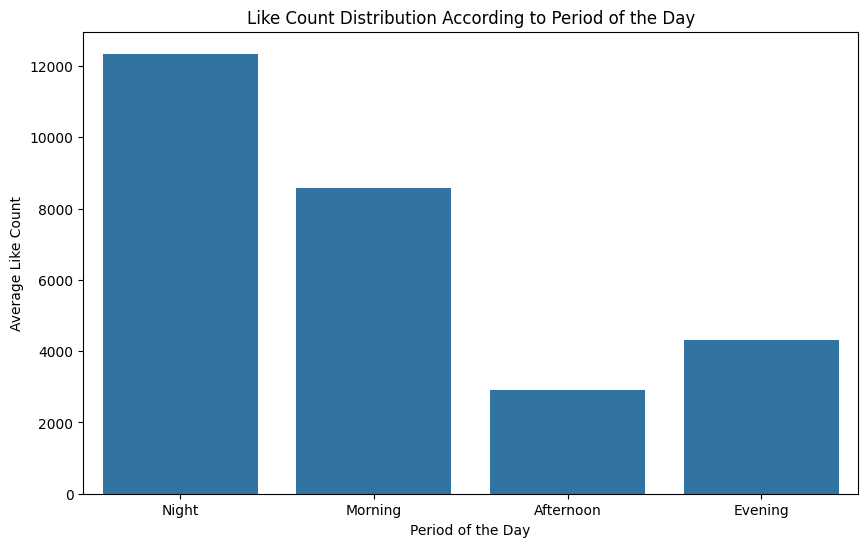

In [6]:
import seaborn as sns

import matplotlib.pyplot as plt

# Group by time of day and calculate the mean like count
time_of_day_likes = df_train.groupby(['time_of_day_Night', 'time_of_day_Morning', 'time_of_day_Afternoon', 'time_of_day_Evening'])['like_count'].mean()

# Create a DataFrame for easier plotting
time_of_day_likes_df = time_of_day_likes.reset_index()
time_of_day_likes_df['time_of_day'] = ['Night', 'Morning', 'Afternoon', 'Evening']

# Plot the like count distribution
plt.figure(figsize=(10, 6))
sns.barplot(x='time_of_day', y='like_count', data=time_of_day_likes_df)
plt.title('Like Count Distribution According to Period of the Day')
plt.xlabel('Period of the Day')
plt.ylabel('Average Like Count')
plt.show()

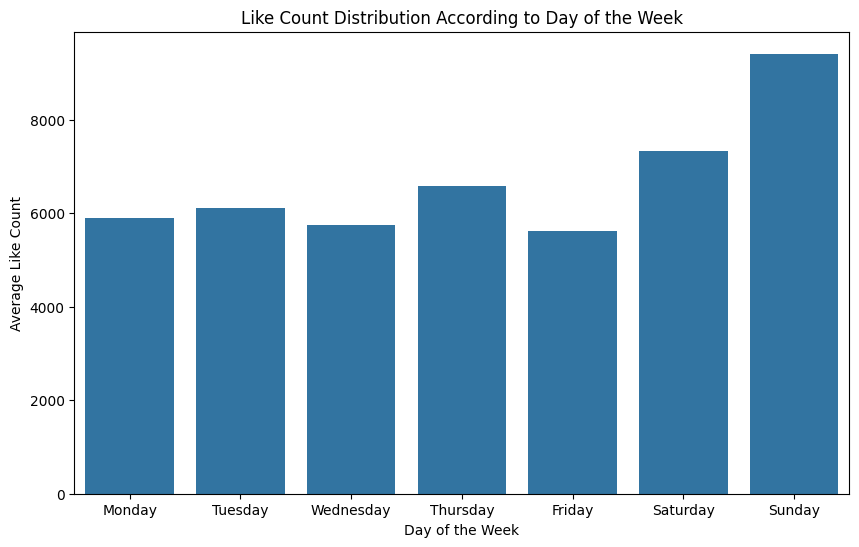

In [12]:
# Group by day of the week and calculate the mean like count
day_of_week_likes = df_train.groupby('day_of_week')['like_count'].mean().reset_index()

# Map day_of_week to actual day names for better readability
day_names = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
day_of_week_likes['day_of_week'] = day_of_week_likes['day_of_week'].map(day_names)

# Plot the like count distribution
plt.figure(figsize=(10, 6))
sns.barplot(x='day_of_week', y='like_count', data=day_of_week_likes, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Like Count Distribution According to Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Like Count')
plt.show()

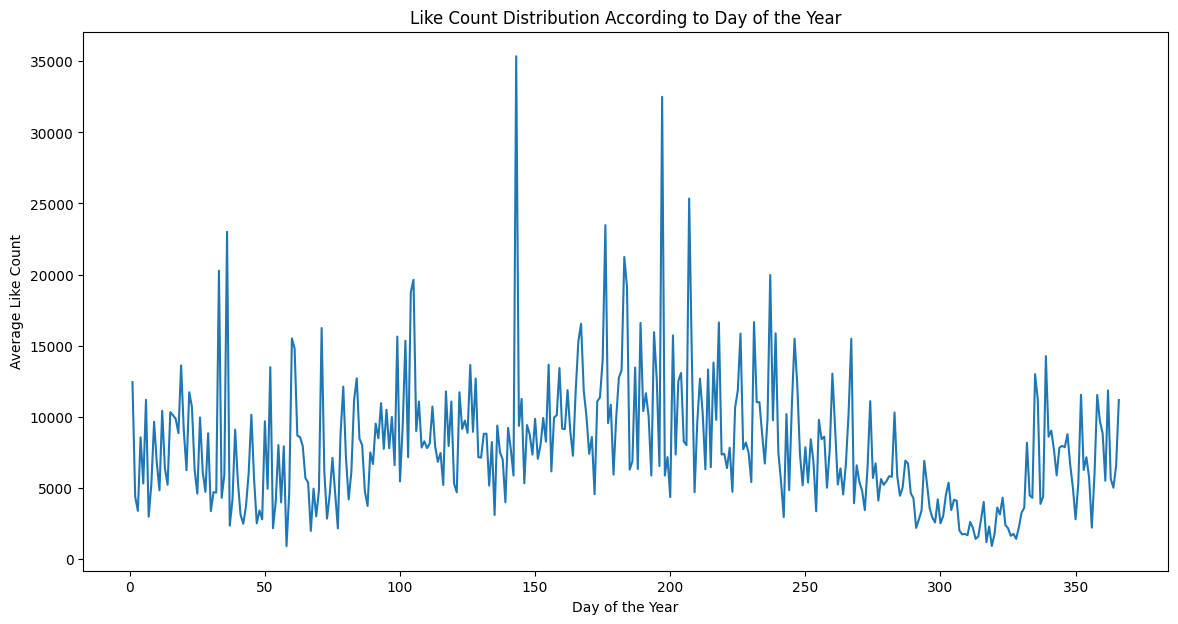

In [13]:
# Group by day of the year and calculate the mean like count
day_of_year_likes = df_train.groupby('day_of_year')['like_count'].mean().reset_index()

# Plot the like count distribution
plt.figure(figsize=(14, 7))
sns.lineplot(x='day_of_year', y='like_count', data=day_of_year_likes)
plt.title('Like Count Distribution According to Day of the Year')
plt.xlabel('Day of the Year')
plt.ylabel('Average Like Count')
plt.show()

In [7]:
print(df_train.isnull().sum()) # Check for missing values

follower_count           0
following_count          0
highlight_reel_count     0
is_verified              0
is_business_account      0
is_private               0
category_name            0
average_like             0
username                 0
media_type               0
comments_count           0
like_count               0
post_length              0
hashtags_count           0
day_of_week              0
day_of_year              0
time_of_day_Night        0
time_of_day_Morning      0
time_of_day_Afternoon    0
time_of_day_Evening      0
dtype: int64


In [9]:
def log_mse_like_counts(y_true, y_pred):
  """
  Calculate the Log Mean Squared Error (Log MSE) for like counts (log(like_count + 1)).

  Parameters:
  - y_true: array-like, actual like counts
  - y_pred: array-like, predicted like counts

  Returns:
  - log_mse: float, Log Mean Squared Error
  """
  # Ensure inputs are numpy arrays
  y_true = np.array(y_true)
  y_pred = np.array(y_pred)

  # Log transformation: log(like_count + 1)
  log_y_true = np.log1p(y_true)
  log_y_pred = np.log1p(y_pred)

  # Compute squared errors
  squared_errors = (log_y_true - log_y_pred) ** 2

  # Return the mean of squared errors
  return np.mean(squared_errors)

In [15]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Separate features (X) and target variable (y)
X = df_train.drop(columns=['like_count', 'username'])  # Drop non-predictive columns
y = df_train['like_count']

# Transform target variable for training
y_log = np.log1p(y)

# Define the model
model = RandomForestRegressor(
    n_estimators=100,  # Reduce the number of trees
    max_depth=15,      # Limit tree depth
    min_samples_split=10,  # Require more samples to split
    random_state=42,
)

# Perform cross-validation
cv_scores = cross_val_score(
    model, 
    X, 
    y_log, 
    cv=5,  # Number of folds in cross-validation
    scoring='neg_mean_squared_error'  
)

# Take the mean of the negative MSE and convert back to positive scale
mean_log_mse = -np.mean(cv_scores)
print(f"Mean MSE from Cross-Validation: {mean_log_mse:.4f}")

# Fit the model on the entire training set
model.fit(X, y_log)


KeyboardInterrupt: 

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor


# Separate features (X) and target variable (y)
X = df_train.drop(columns=['like_count', 'username'])  # Drop non-predictive columns
y = df_train['like_count']


# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


# Transform target variable for training
y_train_log = np.log1p(y_train)

# Train the model
model = RandomForestRegressor(
    n_estimators=100,  # Reduce the number of trees
    max_depth=15,     # Limit tree depth
    min_samples_split=10,  # Require more samples to split
    random_state=42,
)

model.fit(X_train, y_train_log)

# Predict on validation set
y_pred_log = model.predict(X_val)

# Inverse transform predictions to original scale
y_pred = np.expm1(y_pred_log)

# Calculate Log MSE
log_mse = log_mse_like_counts(y_val, y_pred)
print(f"Log MSE: {log_mse}")



Log MSE: 0.487929398114132


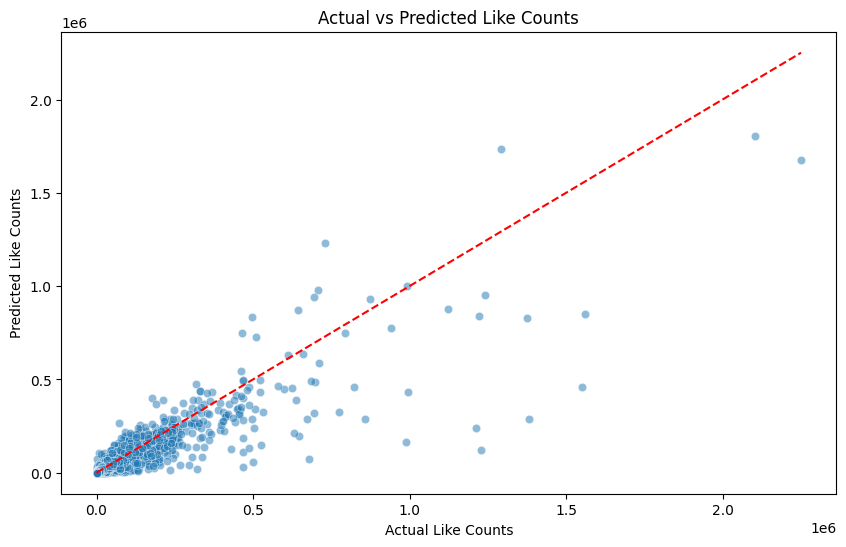

In [17]:
import seaborn as sns

import matplotlib.pyplot as plt

# Create a DataFrame to hold the actual and predicted values
results_df = pd.DataFrame({
    'Actual': y_val,
    'Predicted': y_pred
})

# Plot the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Actual', y='Predicted', data=results_df, alpha=0.5)
plt.plot([results_df['Actual'].min(), results_df['Actual'].max()], [results_df['Actual'].min(), results_df['Actual'].max()], 'r--')
plt.title('Actual vs Predicted Like Counts')
plt.xlabel('Actual Like Counts')
plt.ylabel('Predicted Like Counts')
plt.show()

## Trying GradientBoostingRegressor
- When we applied train-validation splitting, it performed better than random forest. But cross-validation error shows that randomforest outperforms gradientboostingregressor. 

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np

# Separate features (X) and target variable (y)
X = df_train.drop(columns=['like_count', 'username'])  # Drop non-predictive columns
y = df_train['like_count']

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Transform target variable for training
y_train_log = np.log1p(y_train)

# Train the Gradient Boosting model
model = GradientBoostingRegressor(
    n_estimators=100,          # Number of boosting stages
    learning_rate=0.1,         # Shrinkage rate
    max_depth=15,     # Limit tree depth
    min_samples_split=10,      # Minimum samples required to split an internal node
    random_state=42,
)

model.fit(X_train, y_train_log)

# Predict on validation set
y_pred_log = model.predict(X_val)

# Inverse transform predictions to original scale
y_pred = np.expm1(y_pred_log)

# Calculate Log MSE (you'll need to define this function or use a similar evaluation metric)
log_mse = log_mse_like_counts(y_val, y_pred)
print(f"Log MSE: {log_mse:.6f}")


Log MSE: 0.468582


In [75]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Separate features (X) and target variable (y)
X = df_train.drop(columns=['like_count', 'username'])  # Drop non-predictive columns
y = df_train['like_count']

# Transform target variable for training
y_log = np.log1p(y)

# Train the Gradient Boosting model
model = GradientBoostingRegressor(
    n_estimators=100,          # Number of boosting stages
    learning_rate=0.1,         # Shrinkage rate
    max_depth=15,     # Limit tree depth
    min_samples_split=10,      # Minimum samples required to split an internal node
    random_state=42,
)

# Perform cross-validation
cv_scores = cross_val_score(
    model, 
    X, 
    y_log, 
    cv=5,  # Number of folds in cross-validation
    scoring='neg_mean_squared_error'  
)

# Take the mean of the negative MSE and convert back to positive scale
mean_log_mse = -np.mean(cv_scores)
print(f"Mean MSE from Cross-Validation: {mean_log_mse:.6f}")

# Fit the model on the entire training set
model.fit(X, y_log)


Mean MSE from Cross-Validation: 0.894535


GradientBoostingRegressor(max_depth=15, min_samples_split=10, random_state=42)

In [51]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [15, 20],
    'min_samples_split': [10]
}

grid_search = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=2,
    n_jobs=-1,
)

grid_search.fit(X_train, y_train_log)
print("Best Parameters:", grid_search.best_params_)


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END learning_rate=0.05, max_depth=15, min_samples_split=10, n_estimators=200; total time= 2.9min
[CV] END learning_rate=0.05, max_depth=15, min_samples_split=10, n_estimators=200; total time= 2.9min
[CV] END learning_rate=0.05, max_depth=15, min_samples_split=10, n_estimators=200; total time= 2.9min
[CV] END learning_rate=0.05, max_depth=15, min_samples_split=10, n_estimators=200; total time= 2.9min
[CV] END learning_rate=0.05, max_depth=15, min_samples_split=10, n_estimators=200; total time= 2.9min
[CV] END learning_rate=0.05, max_depth=20, min_samples_split=10, n_estimators=200; total time= 3.6min
[CV] END learning_rate=0.05, max_depth=20, min_samples_split=10, n_estimators=200; total time= 3.7min
[CV] END learning_rate=0.05, max_depth=20, min_samples_split=10, n_estimators=200; total time= 3.7min
[CV] END learning_rate=0.1, max_depth=15, min_samples_split=10, n_estimators=200; total time= 2.9min
[CV] END learning_rate=

In [ ]:
# Install xgboost package
%pip install xgboost

## Trying XGBRegressor
- It clearly outperforms both models, for the first two round we've used randomforestregressor, now it's time to use XGB.

In [18]:

from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import numpy as np

# Separate features (X) and target variable (y)
X = df_train.drop(columns=['like_count', 'username'])  # Drop non-predictive columns
y = df_train['like_count']

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Transform target variable for training
y_train_log = np.log1p(y_train)

# Train the XGBoost model
model = XGBRegressor(
    n_estimators=100,          # Number of boosting stages
    learning_rate=0.1,         # Learning rate
    max_depth=15,              # Maximum depth of each tree
    min_child_weight=10,       # Minimum sum of weights of all children for a node to split
    random_state=42,           # Seed for reproducibility
    objective='reg:squarederror',  # Use squared error for regression
)

model.fit(X_train, y_train_log)

# Predict on validation set
y_pred_log = model.predict(X_val)

# Inverse transform predictions to original scale
y_pred = np.expm1(y_pred_log)

# Calculate Log MSE (you'll need to define this function or use a similar evaluation metric)
log_mse = log_mse_like_counts(y_val, y_pred)
print(f"Log MSE: {log_mse:.6f}")


Log MSE: 0.445229


- Cross validation MSE of XGB

In [73]:
import xgboost as xgb
import numpy as np

# Separate features (X) and target variable (y)
X = df_train.drop(columns=['like_count', 'username'])  # Drop non-predictive columns
y = df_train['like_count']

# Transform target variable for training
y_log = np.log1p(y)

# Convert data into DMatrix
dtrain = xgb.DMatrix(X, label=y_log)

# Define parameters for the XGBoost model
params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.1,
    'max_depth': 15,
    'min_child_weight': 10,
    'seed': 42
}

# Perform cross-validation
cv_results = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=100,
    nfold=5,
    metrics='rmse',
    as_pandas=True,
    seed=42
)

print(cv_results)
# Calculate the mean squared error
mean_rmse = cv_results['test-rmse-mean'].iloc[-1]
mean_mse = mean_rmse ** 2
print(f"Mean RMSE from Cross-Validation: {mean_rmse:.6f}")
print(f"Mean MSE from Cross-Validation: {mean_mse:.6f}")

    train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0          2.254647        0.002884        2.257403       0.011366
1          2.052283        0.002695        2.058344       0.010168
2          1.871442        0.002471        1.881116       0.009322
3          1.709884        0.002344        1.723544       0.008602
4          1.565926        0.002288        1.584044       0.007807
..              ...             ...             ...            ...
95         0.340488        0.004333        0.664323       0.006494
96         0.339347        0.004525        0.664231       0.006563
97         0.338152        0.004737        0.664182       0.006513
98         0.337172        0.004645        0.664086       0.006546
99         0.336287        0.004604        0.664037       0.006612

[100 rows x 4 columns]
Mean RMSE from Cross-Validation: 0.664037
Mean MSE from Cross-Validation: 0.440945


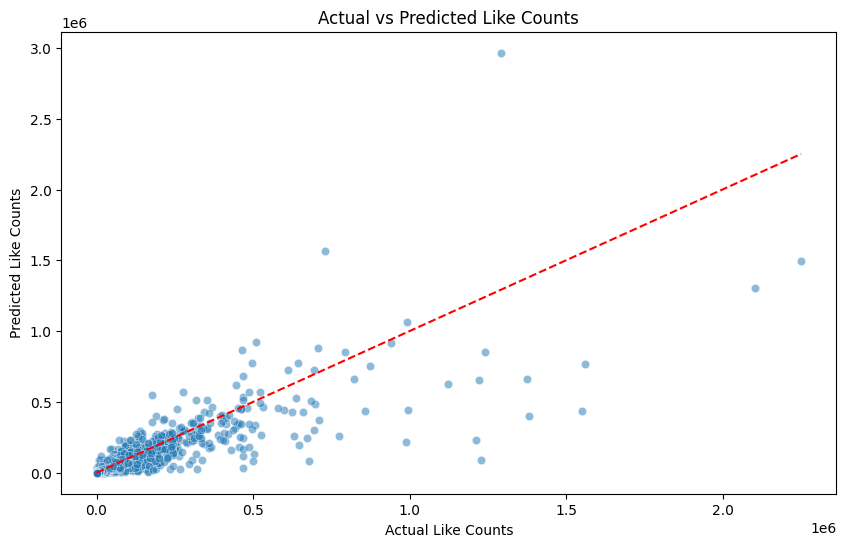

In [19]:
import seaborn as sns

import matplotlib.pyplot as plt

# Create a DataFrame to hold the actual and predicted values
results_df = pd.DataFrame({
    'Actual': y_val,
    'Predicted': y_pred
})

# Plot the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Actual', y='Predicted', data=results_df, alpha=0.5)
plt.plot([results_df['Actual'].min(), results_df['Actual'].max()], [results_df['Actual'].min(), results_df['Actual'].max()], 'r--')
plt.title('Actual vs Predicted Like Counts')
plt.xlabel('Actual Like Counts')
plt.ylabel('Predicted Like Counts')
plt.show()

# Selecting same features for the test set

In [8]:
path = "test-regression-round2.jsonl"


# Step 1: Initialize an empty list for the test data
data = []
# Step 2: Load the test set
with open(path, "rt") as fh:
    for line in fh:
        # Parse the JSON line
        sample = json.loads(line)
        
        user = sample.get("username")
        user_profile = profiles[user] #reaching user profiles which are present in the dataset. 

        
        
        # Extract user-specific features and initialize missing features
        data.append({
            "username": sample.get("username"),  # This will help us map users between test and train
            "timestamp": sample.get("timestamp"),
            "follower_count": user_profile.get("follower_count", 0),
            "following_count": user_profile.get("following_count", 0),
            "highlight_reel_count": user_profile.get("highlight_reel_count", 0),
            "is_verified": user_profile.get("is_verified", False),
            "is_business_account": user_profile.get("is_business_account", False),
            "is_private": user_profile.get("is_private", False),
            "category_name": user_profile.get("category_name", None),
            "media_type": sample.get("media_type", None),
            "comments_count": sample.get("comments_count", 0),
            "id": sample.get("id", ""),
            # Initialize missing features that will be calculated later
            "average_like": None,
            "engagement_rate": None,
        })


# Convert the test data into a DataFrame
df_test = pd.DataFrame(data)

df_test['timestamp'] = pd.to_datetime(df_test['timestamp'])  # Ensure it's a datetime object
# Extract features from timestamp
df_test['hour'] = df_test['timestamp'].dt.hour
df_test['day_of_week'] = df_test['timestamp'].dt.dayofweek
df_test['day_of_year'] = df_test['timestamp'].dt.dayofyear
df_test['month'] = df_test['timestamp'].dt.month
# Example: Bin hours into time of day
bins = [0, 6, 12, 18, 24]
labels = ['Night', 'Morning', 'Afternoon', 'Evening']
df_test['time_of_day'] = pd.cut(df_test['hour'], bins=bins, labels=labels, right=False)
# Convert categorical 'time_of_day' to numerical using one-hot encoding if needed
df_test = pd.get_dummies(df_test, columns=['time_of_day'])

df_test = df_test.drop(columns=['hour', 'month', 'timestamp'])

# Convert Boolean columns to numerical (1/0)
df_test[['time_of_day_Night', 'time_of_day_Morning', 'time_of_day_Afternoon', 'time_of_day_Evening']] = \
    df_test[['time_of_day_Night', 'time_of_day_Morning', 'time_of_day_Afternoon', 'time_of_day_Evening']].astype(int)

#label encoder
df_test["category_name"] = label_encoder.fit_transform(df_test['category_name'])
df_test["media_type"] = label_encoder.fit_transform(df_test['media_type'])

# Convert binary columns (True/False) to 0/1
binary_columns = ['is_verified', 'is_private', 'is_business_account']
for col in binary_columns:
    df_test[col] = df_test[col].astype(int)



# Step 3: Calculate average_like for each user in the test set based on the training set
# Training set is labeled as `df` in your code
# Ensure the training set has the 'username' and 'like_count' columns
user_average_likes = df_train.groupby("username")["like_count"].mean()

# Map average_like from the training set to the test set
df_test["average_like"] = df_test["username"].map(user_average_likes)

# Step 4: Handle missing values for users not present in the training set
df_test["average_like"]=df_test["average_like"].fillna(0)  # Replace NaN with 0 or an appropriate default value

# Step 5: Calculate other derived features if necessary

df_test["engagement_rate"] = df_test["average_like"] / (df_test["follower_count"] + 1e-9)

# Step 6: Prepare df_test for prediction
# Ensure the feature columns in df_test match those used during model training
# Drop unnecessary columns or encode them if required
columns_to_drop = ["username", "id"]  # Drop non-numerical or irrelevant columns
df_test_prepared = df_test.drop(columns=columns_to_drop)

# Define the custom order of columns
custom_order = [
    'follower_count', 
    'following_count', 
    'highlight_reel_count', 
    'is_verified', 
    'is_business_account', 
    'is_private', 
    'category_name', 
    'average_like', 
    'media_type', 
    'comments_count', 
    'day_of_week', 
    'day_of_year', 
    'time_of_day_Night', 
    'time_of_day_Morning', 
    'time_of_day_Afternoon', 
    'time_of_day_Evening'
]
df_test_prepared = df_test_prepared[custom_order]

print(df_test_prepared.isnull().sum())
df_test_prepared.head()

follower_count           0
following_count          0
highlight_reel_count     0
is_verified              0
is_business_account      0
is_private               0
category_name            0
average_like             0
media_type               0
comments_count           0
day_of_week              0
day_of_year              0
time_of_day_Night        0
time_of_day_Morning      0
time_of_day_Afternoon    0
time_of_day_Evening      0
dtype: int64


,follower_count,following_count,highlight_reel_count,is_verified,is_business_account,is_private,category_name,average_like,media_type,comments_count,day_of_week,day_of_year,time_of_day_Night,time_of_day_Morning,time_of_day_Afternoon,time_of_day_Evening
0,10676,744,4,1,1,0,269,1105.828571,1,3,1,33,0,0,1,0
1,58038,94,69,1,0,0,269,1864.200000,2,63,3,327,0,0,1,0
2,72118,417,20,0,0,0,238,2044.285714,2,27,2,88,0,0,0,1
3,153063,1029,0,1,0,0,17,22095.971429,0,125,2,109,0,0,1,0
4,512923,733,19,1,0,0,243,13622.057143,0,108,4,265,0,1,0,0


# Making the predictions on the test set, and then recording the results to json file.

In [9]:
# Step 7: Predict like counts
# Make predictions with your trained model (e.g., RandomForestRegressor, StackingRegressor, etc.)
predictions_log = model.predict(df_test_prepared)

# Step 8: Inverse transform predictions if necessary
# If your model predicted log-transformed like counts, reverse the transformation
predictions = np.expm1(predictions_log)  # Transform back to original scale


# Step 9: Add predictions to df_test
df_test["predicted_like_count"] = predictions


# Prepare the output dictionary
output_predictions = {}

# Iterate over the test set to fill the output dictionary
for _, row in df_test.iterrows():
    post_id = row["id"]  # Replace with the actual column name for the unique ID
    predicted_like_count = row["predicted_like_count"]
    output_predictions[post_id] = int(predicted_like_count)  # Ensure prediction is saved as an integer

# Write the output to a JSON file
output_path = "prediction-regression-round2-deneme.json"
with open(output_path, "w") as output_file:
    json.dump(output_predictions, output_file, indent=4)

print(f"Predictions saved to {output_path}")

Predictions saved to prediction-regression-round2-deneme.json
